# Deep Reinforcement Learning - Assignment 3
## Training and Comparing Meta-Learning and Transfer-Learning using an Actor-Critic agent

This notebook implements, trains, and evaluates Policy Gradient agents.

### Assignment Structure:
- **Section 1**: One step Actor-Critic for Different Tasks
- **Section 2**: Fine-Tuning a Trained Model for Different Tasks:
    - CartPole-v1
    - Acrobot-v1
    - MountainCarContinuous-v0 (discretized via adapters)   
- **Section 3**: Transfer-Learning
- **Section 4**: Comparison and Analysis

---

In [ ]:
# # Connect notebook to GitHub repo, for GoogleColab

# import os
# if not os.path.exists('TransferLearning'):
#     !git clone https://github.com/shaharoded/TransferLearning.git
# os.chdir('TransferLearning')
# !git pull origin main

Cloning into 'TransferLearning'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 19 (delta 3), reused 19 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (19/19), 205.62 KiB | 8.57 MiB/s, done.
Resolving deltas: 100% (3/3), done.
From https://github.com/shaharoded/TransferLearning
 * branch            main       -> FETCH_HEAD
Already up to date.


In [1]:
# Setup: Add project root to Python path
import os
import sys
from __future__ import annotations

# Get the notebook's directory
notebook_dir = os.path.abspath('')
project_root = notebook_dir  # Since notebook is in project root

# Add to path if not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print(f"Project root: {project_root}")

Project root: c:\Users\shaha\Work\Personal\DRL\MetaLearning


In [6]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib
from dataclasses import asdict

# PyTorch
import torch

# Gymnasium
import gymnasium as gym

# Disable PyTorch 2.0+ compilation features that might cause issues
torch._dynamo.config.suppress_errors = True
import torch._dynamo
torch._dynamo.disable()

# Force complete module reload
modules_to_remove = [key for key in list(sys.modules.keys()) 
                    if 'agent' in key.lower() or 'src' in key or 'utils' in key or 'ffnn' in key]
for module in modules_to_remove:
    del sys.modules[module]

# Import custom modules
import src.adapters
import src.ffnn
import src.agent
import src.train
import src.training_utils
import src.wrappers

from src.adapters import get_default_env_specs
from src.agent import AgentConfig, ActorCriticAgent
from src.train import train_actor_critic
from src.training_utils import plot_training_curves_grid, plot_diagnostics_grid, summarize_run
from src.wrappers import MountainCarRewardShaping

# Reload to get latest changes (run this cell again after editing source files)
importlib.reload(src.adapters)
importlib.reload(src.ffnn)
importlib.reload(src.agent)
importlib.reload(src.train)
importlib.reload(src.training_utils)
importlib.reload(src.wrappers)

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- SEED SETTING ---
SEED = 42
def set_seeds(seed=SEED, env=None):
    """Set seeds for reproducibility across numpy, random, torch, and gym."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
    if env is not None:
        env.action_space.seed(seed)
        env.reset(seed=seed)
        print(f"✓ Environment seeded with {seed}")

set_seeds()
print(f"✓ Global seeds set to {SEED}")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ Modules reloaded successfully")

✓ Global seeds set to 42
✓ PyTorch version: 2.8.0+cpu
✓ Modules reloaded successfully


In [7]:
STATE_DIM = 6
ACTION_DIM = 5

# Moving average window for convergence
MA_WINDOW = 100

specs = get_default_env_specs(state_dim=STATE_DIM, action_dim=ACTION_DIM)

# Quick sanity check: masks and dims
for name, spec in specs.items():
    print(name, "obs_dim=", spec.obs_dim, "state_dim=", spec.state_dim, "action_dim=", spec.action_dim, "valid_actions=", spec.valid_action_indices)

cartpole obs_dim= 4 state_dim= 6 action_dim= 5 valid_actions= (0, 1)
acrobot obs_dim= 6 state_dim= 6 action_dim= 5 valid_actions= (0, 1, 2)
mountaincar obs_dim= 2 state_dim= 6 action_dim= 5 valid_actions= (0, 1, 2, 3, 4)


## Part 1: Training Individual Networks 

In this part, using the same architectures (+ adapters), we'll train seperate networks per task

In [ ]:
# Shared Agent architecture
# Agent learning config (If needed: override per env)
BASE_AGENT_CFG = AgentConfig(
    gamma=0.99,
    hidden_sizes=[128],
    actor_lr=5e-4,
    critic_lr=1e-3,
    entropy_coef=0.01,
    grad_clip_norm=None,
)

# Task configs (target_reward is only used for plotting purposes)
TASKS = {
    "cartpole": {
        "gym_id": "CartPole-v1",
        "target_reward": 475,
        "target_success_rate": 0.95,
        "success_criterion": {"type": "length", "threshold": 500, "comparison": "greater_equal"}, # Solved task at reward == 500
        "max_episodes": 2000,
        "max_steps": 500,
        "agent_cfg": BASE_AGENT_CFG,
    },
    "acrobot": {
        "gym_id": "Acrobot-v1",
        "target_reward": -100,
        "target_success_rate": 0.95,
        "success_criterion": {"type": "reward", "threshold": -100, "comparison": "greater_equal"}, # Solved task at reward == -100
        "max_episodes": 4000,
        "max_steps": 500,
        "agent_cfg": BASE_AGENT_CFG,
    },
    "mountaincar": {
        "gym_id": "MountainCarContinuous-v0",
        "target_reward": 150, # Adapted to reward shaping
        "target_success_rate": 0.95,
        "success_criterion": {"type": "length", "threshold": 999, "comparison": "less"}, # If reached the flag within 999 steps -> Success
        "max_episodes": 10000,
        "max_steps": 1000,
        "agent_cfg": AgentConfig(**{**asdict(BASE_AGENT_CFG), "entropy_coef": 0.10})  # reduce exploration to exploit successful strategy
    }
}

In [11]:
histories = {}

for env_name, cfg in TASKS.items():
    print("\n" + "="*80)
    print(f"Training {env_name} ({cfg['gym_id']})")
    print("="*80)

    # 1) Create env
    env = gym.make(cfg["gym_id"])
    
    # Apply reward shaping wrapper for MountainCar
    if env_name == "mountaincar":
        env = MountainCarRewardShaping(env, position_weight=10.0, velocity_weight=1.0)
        print("✓ Reward shaping applied for MountainCar")
    
    env.reset(seed=SEED)
    env.action_space.seed(SEED)

    # 2) Create agent
    agent = ActorCriticAgent(
        env_spec=specs[env_name],
        config=cfg["agent_cfg"],
        seed=SEED,
    )

    # 3) Train agent
    histories[env_name] = train_actor_critic(
        env=env,
        agent=agent,
        max_episodes=cfg["max_episodes"],
        max_steps_per_episode=cfg["max_steps"],
        ma_window=MA_WINDOW,
        target_success_rate=cfg.get("target_success_rate"),
        success_criterion=cfg.get("success_criterion"),
        verbose=True,
        print_every=50,
        reset_seed_base=SEED,
    )

    env.close()

    print("Summary:", summarize_run(histories[env_name]))


Training cartpole (CartPole-v1)
✓ Agent device: cpu
[cartpole] ep=   1 MA_R(100)=   27.00 MA_len(100)=  27.0 success_rate=0.00%
[cartpole] ep=  50 MA_R(100)=   19.38 MA_len(100)=  19.4 success_rate=0.00%
[cartpole] ep= 100 MA_R(100)=   18.69 MA_len(100)=  18.7 success_rate=0.00%
[cartpole] ep= 150 MA_R(100)=   25.78 MA_len(100)=  25.8 success_rate=0.00%
[cartpole] ep= 200 MA_R(100)=   38.62 MA_len(100)=  38.6 success_rate=0.00%
[cartpole] ep= 250 MA_R(100)=   56.67 MA_len(100)=  56.7 success_rate=0.00%
[cartpole] ep= 300 MA_R(100)=  116.91 MA_len(100)= 116.9 success_rate=2.00%
[cartpole] ep= 350 MA_R(100)=  137.11 MA_len(100)= 137.1 success_rate=2.00%
[cartpole] ep= 400 MA_R(100)=  147.43 MA_len(100)= 147.4 success_rate=2.00%
[cartpole] ep= 450 MA_R(100)=  251.74 MA_len(100)= 251.7 success_rate=20.00%
[cartpole] ep= 500 MA_R(100)=  300.84 MA_len(100)= 300.8 success_rate=37.00%
[cartpole] ep= 550 MA_R(100)=  385.76 MA_len(100)= 385.8 success_rate=59.00%
[cartpole] ep= 600 MA_R(100)=  4

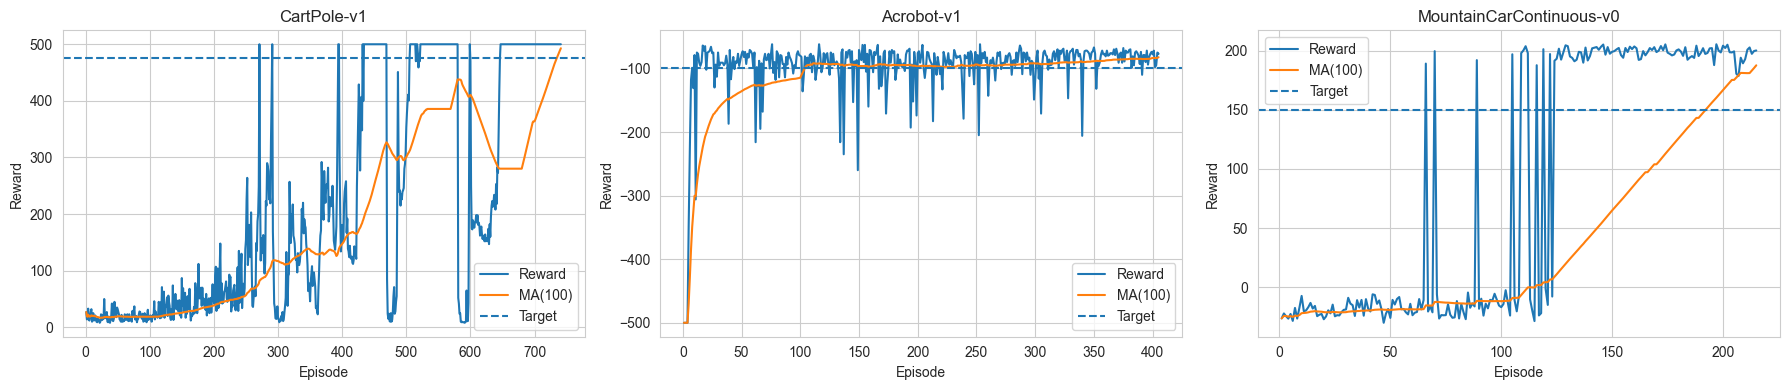

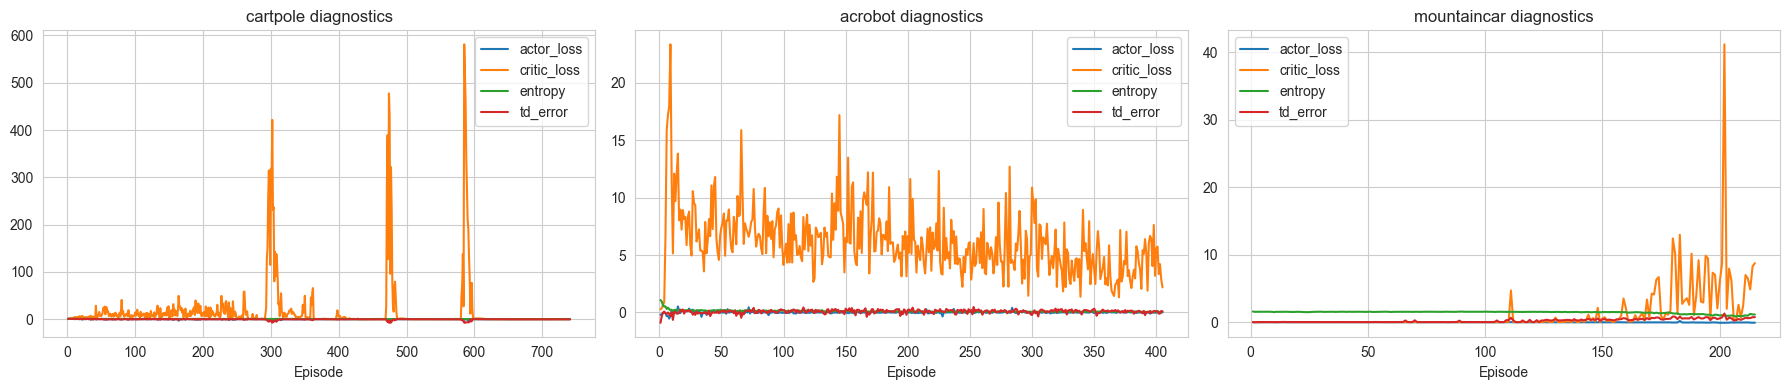

In [ ]:
# Analyze
order = ["cartpole", "acrobot", "mountaincar"]

thresholds = {k: TASKS[k]["target_reward"] for k in order}
titles = {k: TASKS[k]["gym_id"] for k in order}

plot_training_curves_grid(
    histories,
    order=order,
    titles=titles,
    thresholds=thresholds,
    grid_shape=(1, 3),
    figsize=(18, 4),
)

plot_diagnostics_grid(
    histories,
    order=order,
    grid_shape=(1, 3),
    figsize=(18, 4),
)